# **Validation Suite**

## Purpose and Setup
This notebook will allow you to test the output from WRF-GHG against surface, upper air, and satelite observations.

The next cell imports modules needed to work properly

In [1]:
import os
import wrf
import numpy as np
import pandas as pd
from datetime import datetime as dt
from netCDF4 import Dataset as Ds #type: ignore
from termcolor import cprint
import pytz
from numpy import unravel_index
import collections.abc as c
import numpy.typing as npt
import metpy as mp
from metpy.units import units
from metpy.calc import wind_components
from xarray import DataArray, Dataset
import xarray as xr
import netCDF4
from enum import IntFlag, auto
import matplotlib.pyplot as plt
units.define('ppb = 1e-9')

### *Bit-flags for Validation failure*

This class is used for setting a bit-flag to comunicate which variable didn't validate.

In [2]:
class Bitflag(IntFlag):
    PRES = auto()
    TEMP = auto()
    DEWP = auto()
    U = auto()
    V = auto()
    T2 = auto()
    TD2 = auto()
    SLP = auto()
    U10 = auto()
    V10 = auto()
    XCO2 = auto()
    XCO = auto()
    XCH4 = auto()

### *Base class*

This class is used for all the following classes in order to give some basic location data to each class.

In [3]:
class Base_point:
    '''
    Base_point: parent class for validation. Sets location name.
    '''
    def __init__(self, loc: str, **kwargs) -> None:
        self.loc: str = loc
    @staticmethod
    def _rmse(x:npt.ArrayLike, y:npt.ArrayLike) -> float:
        error = x - y
        sqr_error = error**2
        mse = np.mean(sqr_error)
        rmse = mse**(1/2)
        return rmse
    @staticmethod
    def _mean_bias(x:npt.ArrayLike, y:npt.ArrayLike) -> float:
        return np.mean(x - y)

### *Upper air (UA) class*

This class is used to set the attributes for any data objects that cares about upper air data. This is usually the WRF data that you're testing or the radiosonde data you use for validation. It inherits from the base class.

In [4]:
class UA_point(Base_point):
    def __init__(self, loc: str, **kwargs) -> None:
        super().__init__(loc, **kwargs)
    def __eq__(self, other: object) -> bool:
        try:
            results: npt.NDArray[np.bool_] = np.empty(5, np.bool_)
            results[0] = self._rmse(self.p, other.p) #! add validation limit here
            results[1] = self._rmse(self.t, other.t) #! add validation limit here
            results[2] = self._rmse(self.td, other.td) #! add validation limit here
            results[3] = self._rmse(self.wdir, other.wdir) #! add validation limit here
            results[4] = self._rmse(self.wspd, other.wspd) #! add validation limit here
            result: bool = bool(results.all())
        except AttributeError:
            if isinstance(self, WRF_point):
                result: bool = other.__eq__(self)
            else:
                raise NotImplementedError('Compairison not implemented')
        finally:
            global flags
            flags = 0
            if not result:
                for i, test in enumerate(results):
                    if not test:
                        match i:
                            case 0:
                                flags = flags | Bitflag.PRES
                            case 1:
                                flags = flags | Bitflag.TEMP
                            case 2:
                                flags = flags | Bitflag.DEWP
                            case 3:
                                flags = flags | Bitflag.U
                            case 4:
                                flags = flags | Bitflag.V
                            case _:
                                raise RuntimeError(f'Invalid flag set: {i}')
            return result

### *Satelite (Sat) class*

This class is used to set the attributes for any data objects that cares about satelite data. This is usually the WRF data or TROPOMI or OCO-2 data. It inherits from the base class. **Note**: The respective classes for TROPOMI and OCO-2 are still in development (9-9-2024)

In [5]:
class Sat_point(Base_point):
    def __init__(self, loc: str, **kwargs) -> None:
        super().__init__(loc, **kwargs)
    def sat_loc(self, ulat: float, ulon: float, lats: c.Iterable[float], lons: c.Iterable[float]) -> tuple[int, int] | int:
        R: int = 6371000
        lat1: npt.NDArray[np.float32] | float = np.radians(ulat)
        lat2: npt.NDArray[np.float32] = np.radians(lats)
        delta_lat: npt.NDArray[np.float32] = np.radians(lats-ulat)
        delta_lon: npt.NDArray[np.float32] = np.radians(lons-ulon)
        a: npt.NDArray[np.float32] = (np.sin(delta_lat/2))*(np.sin(delta_lat/2))+(np.cos(lat1))*(np.cos(lat2))*(np.sin(delta_lon/2))*(np.sin(delta_lon/2))
        c: npt.NDArray[np.float32] = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
        d: npt.NDArray[np.float32] = R*c
        if d.ndim == 1:
            return d.argmin()
        else:
            x: int = 0
            y: int = 0
            x, y = unravel_index(d.argmin(),d.shape)
            return x,y
    def __eq__(self, other: object) -> bool:
        result: bool | None = None
        try:
            if isinstance(self, Tropomi_point) or (isinstance(self, WRF_point) and isinstance(other, Tropomi_point)):
                results: npt.NDArray[np.bool_] = np.empty(2, np.bool_)
                results[0] = self._rmse(self.xch4, other.xch4) <= 1.e-1
                results[1] = self._rmse(self.xco, other.xco) <= 1.e-1
                result = bool(results.all())
            #! elif for OCO-2 here
        except AttributeError:
            if isinstance(self, WRF_point):
                result = other.__eq__(self)
            else:
                raise NotImplementedError('Compairison not implemented')
        else:
            if result is None:
                if isinstance(self,WRF_point):
                    result = other.__eq__(self)
                else:
                    raise NotImplementedError('Compairison not implemented')
            else:
                pass
        finally:
            global flags
            flags = 0
            if not result:
                for i, test in enumerate(results):
                    if not test:
                        if isinstance(self, Tropomi_point) or (isinstance(self, WRF_point) and isinstance(other, Tropomi_point)): 
                            match i:
                                case 0:
                                    flags = flags | Bitflag.XCH4
                                case 1:
                                    flags = flags | Bitflag.XCO
                                case _:
                                    raise RuntimeError(f'Invalid flag set: {i}')
                        else:
                            match i:
                                case 0:
                                    flags = flags | Bitflag.XCO2
                                case _:
                                    raise RuntimeError(f'Invalid flag set: {i}')
            return result

### *Surface class*

This class is used to set the attirbutes for any data object that cares about surface data. This is usually the WRF data or the ASOS observation data. It inherits from the base class.

In [7]:
class Surface_point(Base_point):
    def __init__(self, loc: str, **kwargs) -> None:
        super().__init__(loc, **kwargs)
    def __eq__(self, other: object) -> bool:
        global flags
        if isinstance(self, Obs_point) and self.met:
            try:
                results: npt.NDArray[np.bool_] = np.empty(5, np.bool_)
                results[0] = self._rmse(self.T2, other.T2) <= 5. * units.kelvin
                results[1] = self._rmse(self.td2, other.td2) <= 5. * units.kelvin
                results[2] = self._rmse(self.slp, other.slp) <= 2.0 * units.hPa
                results[3] = self._rmse(self.u10, other.u10) <= 2.24 * units('m/s')
                results[4] = self._rmse(self.v10, other.v10) <= 2.24 * units('m/s')
                result: bool = bool(results.all())
            except AttributeError:
                if isinstance(self, WRF_point):
                    result: bool = other.__eq__(self)
                else:
                    raise NotImplementedError('Comparison not implemented')
            finally:
                flags = 0
                if not result:
                    for i, test in enumerate(results):
                        if not test:
                            match i:
                                case 0:
                                    flags = flags | Bitflag.T2
                                case 1:
                                    flags = flags | Bitflag.TD2
                                case 2:
                                    flags = flags | Bitflag.SLP
                                case 3:
                                    flags = flags | Bitflag.U10
                                case 4:
                                    flags = flags | Bitflag.V10
                                case _:
                                    raise RuntimeError(f'Invalid flag set: {i}')
                return result
        if isinstance(self, Obs_point) and self.chem:
            try:
                results: npt.NDArray[np.bool_] = np.empty(3, np.bool_)
                results[0] = self._rmse(self.xch4, other.xch4) <= 100. * units.ppb
                results[1] = self._rmse(self.xco2, other.xco2) <= 10. * units.ppm
                results[2] = self._rmse(self.xco, other.xco) <= 100. * units.ppb
                result: bool = bool(results.all())
            except AttributeError:
                if isinstance(self, WRF_point):
                    result: bool = other.__eq__(self)
                else:
                    raise NotImplementedError('Comparison not implemented')
            finally:
                flags = 0
                if not result:
                    for i, test in enumerate(results):
                        if not test:
                            match i:
                                case 0:
                                    flags = flags | Bitflag.XCH4
                                case 1:
                                    flags = flags | Bitflag.XCO2
                                case 2:
                                    flags = flags | Bitflag.XCO
                                case _:
                                    raise RuntimeError(f'Invalid flag set: {i}')
                return result


### *WRF class*

This class ingests the wrfout data that you need to run the validation suite. Since it's what we're testing, it inherits from UA, Sat, and Surface classes.

In [13]:
class WRF_point(Surface_point,Sat_point,UA_point):
    '''
    WRF_point: sets up validation point using WRF data. Reads T2, TD2, SLP, and 10m Wind speed/direction. Inherits from Base_point.
    '''
    def __init__(self, wrffile: Dataset, lat: float, lon: float, loc: str, chem: bool | None = None, **kwargs) -> None:
        super().__init__(loc,**kwargs)
        wrf.omp_set_num_threads(wrf.omp_get_num_procs())
        self.lat: float = lat
        self.lon: float = lon
        self.x: float | npt.NDArray | DataArray
        self.y: float | npt.NDArray | DataArray
        self.x, self.y = wrf.ll_to_xy(wrffile,self.lat,self.lon)
        self.vars: list[str] = ['T2', 'td2', 'slp','uvmet10','p','temp','td','uvmet']
        for var in self.vars:
            if var == 'T2':
                try:
                    self.T2: DataArray = wrf.getvar(wrffile, var, wrf.ALL_TIMES)[..., self.y, self.x].metpy.quantify()
                except MemoryError:
                    self.T2: DataArray = self.memory_loop(wrffile, var)
            elif var == 'td2':
                try:
                    self.td2: DataArray = wrf.getvar(wrffile, var, wrf.ALL_TIMES, units='K')[..., self.y, self.x].metpy.quantify()
                except MemoryError:
                    self.td2: DataArray = wrf._memory_loop(wrffile, var, 'K')
            elif var == 'slp':
                try:
                    self.slp: DataArray = wrf.getvar(wrffile, var, wrf.ALL_TIMES, units='hPa')[..., self.y, self.x].metpy.quantify()
                except MemoryError:
                    self.slp: DataArray = self._memory_loop(wrffile, var, 'hPa')
            elif var == 'uvmet10':
                try:
                    self.u10, self.v10 = wrf.getvar(wrffile, var, wrf.ALL_TIMES)[..., self.y, self.x].metpy.quantify() #type: tuple[DataArray, DataArray]
                except MemoryError:
                    self.u10, self.v10 = self._memory_loop(wrffile, var) #type: tuple[DataArray, DataArray]
            elif var == 'p':
                try:
                    self.p: DataArray = wrf.getvar(wrffile, var, wrf.ALL_TIMES, units='hPa')[..., self.y, self.x].metpy.quantify()
                except MemoryError:
                    self.p: DataArray = self._memory_loop(wrffile, var, 'hPa')
            elif var == 'temp':
                try:
                    self.t: DataArray = wrf.getvar(wrffile, var, wrf.ALL_TIMES)[..., self.y, self.x].metpy.quantify()
                except MemoryError:
                    self.t: DataArray = self._memory_loop(wrffile, var)
            elif var == 'td':
                try:
                    self.td: DataArray = wrf.getvar(wrffile, var, wrf.ALL_TIMES, units='K')[..., self.y, self.x].metpy.quantify()
                except MemoryError:
                    self.td: DataArray = self._memory_loop(wrffile, var, 'K')
            elif var == 'uvmet':
                try:
                    self.u, self.v = wrf.getvar(wrffile, var, wrf.ALL_TIMES)[..., self.y, self.x].metpy.quantify() #type: tuple[DataArray, DataArray]
                except MemoryError:
                    self.u, self.v = self._memory_loop(wrffile, var) #type: tuple[DataArray, DataArray]
        ## ! Next if/elif block needs to be edited depending on WRF-GHG output structure (include converting units) ! ## 
        try:
            self.sfc_pres: DataArray = wrf.getvar(wrffile, 'PSFC')[..., self.y, self.x] #! may need to calculate or may be in WRF output
        except MemoryError:
            self.sfc_pres: DataArray = self._memory_loop(wrffile, 'PSFC') #! may need to calculate or may be in WRF output
        if chem:
            self.xch4: npt.ArrayLike = self._extract_ghg(wrffile, 'xch4')
            self.xco: npt.ArrayLike = self._extract_ghg(wrffile, 'xco')
            self.xco2: npt.ArrayLike = self._extract_ghg(wrffile, 'xco2')
    def _extract_ghg(self, wrffile: Dataset, chem: str) -> npt.ArrayLike:
        if chem == 'xch4':
            _ant: DataArray = wrf.getvar(wrffile,'CH4_ANT', wrf.ALL_TIMES)[..., self.y, self.x]
            _bck: DataArray = wrf.getvar(wrffile,'CH4_BCK',wrf.ALL_TIMES)[..., self.y, self.x]
            _tst: DataArray = wrf.getvar(wrffile,'CH4_TST',wrf.ALL_TIMES)[..., self.y, self.x]
        elif chem == 'xco2':
            _ant: DataArray = wrf.getvar(wrffile,'CO2_ANT',wrf.ALL_TIMES)[..., self.y, self.x]
            _bck: DataArray = wrf.getvar(wrffile,'CO2_BCK',wrf.ALL_TIMES)[..., self.y, self.x]
            _tst: DataArray = wrf.getvar(wrffile,'CO2_TST',wrf.ALL_TIMES)[..., self.y, self.x]
        elif chem == 'xco':
            _ant: DataArray = wrf.getvar(wrffile,'CO_ANT',wrf.ALL_TIMES)[..., self.y, self.x]
            _bck: DataArray = wrf.getvar(wrffile,'CO_BCK',wrf.ALL_TIMES)[..., self.y, self.x]
            #_tst = wrffile['CO_BIO'][0, :, self.y, self.x] ##?
            _tst: npt.NDArray = np.zeros_like(_bck)
        _ghg = _tst + _ant -_bck
        if ((len(_ghg) == len(self.p)) and (_ghg.ndim == 1)) or ((len(_ghg[0,:]) == len(self.p[0,:])) and (_ghg.ndim == 2)):
            pres_bound: npt.NDArray = np.empty_like(self.p)
            for i, pres in enumerate(self.p):
                if i == 0:
                    pres_bound[i] = self.sfc_pres
                    pres_bound[i+1] = pres_bound[i] + (2*(pres-pres_bound[i]))
                else:
                    try:
                        pres_bound[i+1] = pres_bound[i] + (2*(pres-pres_bound[i]))
                    except IndexError:
                        pass
        p_layer_diff: npt.NDArray = np.array([pres_bound[i]-pres_bound[i-1] for i in range(1,len(pres_bound))]) #! This may need a value at beginning for xch4[0]
        p_diff: float = pres_bound[0] - pres_bound[-1]
        return (np.sum(_ghg*p_layer_diff)/p_diff) * units.ppm
    @staticmethod
    def _memory_loop(wrffile, var, x=None, y=None, units=None):
        length = len(wrffile)
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        if length % 24 == 0:
            loops = length // 24
            if loops == 1:
                loops = 3
            elif loops == 24:
                loops = 48
            loop_seg = length // loops
            if var not in ['uvmet10','uvmet']:
                var_array = []
                for n in range(0,loops):
                    if units is not None:
                        var_array.append(wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES,units=units)[...,y,x].metpy.quantify())
                    else:
                        var_array.append(wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify())
                return xr.concat(var_array, dims='Time')
            else:
                u_array = []
                v_array = []
                for n in range(0,loops):
                    if units is not None:
                        u_temp, v_temp = wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify()
                    else:
                        u_temp, v_temp = wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify()
                    u_array.append(u_temp)
                    v_array.append(v_vemp)
                    del u_temp, v_temp
                return xr.concat(u_array, dims='Time'), xr.concat(v_array, dims='Time')
        elif (length - 1) % 24 == 0:
            loops = (length-1) // 24
            if loops == 1:
                loops = 3
            elif loops == 24:
                loops = 48
            loop_seg = (length-1) // loops
            if var not in ['uvmet10','uvmet']:
                var_array = []
                for n in range(0,loops):
                    if units is not None:
                        var_array.append(wrf.getvar(wrffile[(n*loop_seg):((n+1)*loop_seg)],var,wrf.ALL_TIMES,units=units)[...,y,x].metpy.quantify())
                    else:
                        var_array.append(wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify())
                if units is not None:
                    var_array.append(wrf.getvar(wrffile[loops*loop_seg:],var,wrf.ALL_TIMES,units=units)[...,y,x].metpy.quantify())
                else:
                    var_array.append(wrf.getvar(wrffile[loops*loop_seg:],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify())
                return xr.concat(var_array, dims='Time')
            else:
                u_array = []
                v_array = []
                for n in range(0,loops):
                    if units is not None:
                        u_temp, v_temp = wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify()
                    else:
                        u_temp, v_temp = wrf.getvar(wrffile[n*loop_seg:(n+1)*loop_seg],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify()
                    u_array.append(u_temp)
                    v_array.append(v_vemp)
                    del u_temp, v_temp
                if units is not None:
                    u_temp, v_temp = wrf.getvar(wrffile[loops*loop_seg:],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify()
                else:
                    u_temp, v_temp = wrf.getvar(wrffile[loops*loop_seg:],var,wrf.ALL_TIMES)[...,y,x].metpy.quantify()
                u_array.append(u_temp)
                v_array.append(v_vemp)
                del u_temp, v_temp
                return xr.concat(u_array, dims='Time'), xr.concat(v_array, dims='Time')
        else:
            raise RuntimeError(f'loop length not defined ({length = })')
    def __str__(self) -> str:
        return f'{self.loc} WRF Point has a temperature of {self.T2} K, a dewpoint of {self.td2} K, a slp of {self.slp} hPa, and the wind is {self.wspd10} m s^-1 at {self.wdir10} degrees.'

### *Obs_point Class*

This class ingests surface observation data from ASOS stations to test against WRF data. This inherits from Surface point.

In [9]:
class Obs_point(Surface_point):
    '''
    Obs_point: sets up validation point for observation. Reads T2, TD2, slp, and wind speed/direction from ASOS data. Inherits from Base_point.
    '''
    def __init__(self, loc: str, obsfile: str, obstime: dt | list[dt], *, met=True, chem=False, **kwargs) -> None:
        super().__init__(loc, **kwargs)
        self.met = met
        self.chem = chem
        utc = pytz.utc
        if isinstance(obstime, list):
            obstime = [utc.localize(date) for date in obstime]
        else:
            obstime = utc.localize(obstime) 
        if self.met:
            data: pd.DataFrame = pd.read_csv(obsfile,na_values='M',parse_dates=['valid'],date_format='%Y-%m-%d %H:%M')
            data.valid = pd.to_datetime(data.valid).dt.tz_localize(utc)
            if loc in ['JFK Airport','JFK','NYC/JFK', 'LaGuardia Airport', 'LGA', 'NYC/LGA', 'Central Park','NYC']:
                delta = 540
            else:
                delta = 420
            idx = []
            if not isinstance(obstime, list):
                for i, obs in enumerate(data.valid):
                    if abs(obs.timestamp() - obstime.timestamp()) == delta:
                        idx.append(i)
                        break
            else:
                for time in obstime:
                    for i, obs in enumerate(data.valid):
                        if abs(obs.timestamp() - time.timestamp()) == delta:
                            idx.append(i)
                            break
            #print(idx)
            if isinstance(obstime,list):
                obstime = [date.replace(tzinfo=None) for date in obstime]
            else:
                obstime = obstime.replace(tzinfo=None)
            ds = Dataset.from_dataframe(data.iloc[idx])
            ds = ds.rename({'index':'Time'}).assign_coords({'Time':obstime})
            del data
            self.T2: DataArray = (ds.tmpc * units.degC).metpy.convert_to_base_units()
            self.td2: DataArray = (ds.dwpc * units.degC).metpy.convert_to_base_units()
            self.slp: DataArray = ds.mslp * units.hPa
            self.u10, self.v10 = wind_components((ds.sped * 0.44704) * units('m/s'), ds.drct * units.deg)
            del ds
        if self.chem:
            cols = ['UTC_time','CH4_ppb','CO2_ppm','CO_ppb']
            data = pd.read_csv(obsfile, na_values='NA', skiprows=6, usecols=cols,parse_dates=['UTC_time'],date_format='%Y-%m-%d %H:%M')
            data.UTC_time = pd.to_datetime(data.UTC_time).dt.tz_localize(utc)
            idx = []
            if not isinstance(obstime, list):
                for i, obs in enumerate(data.valid):
                    if abs(obs.timestamp() - obstime.timestamp()) == delta:
                        idx.append(i)
                        break
            else:
                for time in obstime:
                    for i, obs in enumerate(data.valid):
                        if abs(obs.timestamp() - time.timestamp()) == delta:
                            idx.append(i)
                            break
            #print(idx)
            if isinstance(obstime,list):
                obstime = [date.replace(tzinfo=None) for date in obstime]
            else:
                obstime = obstime.replace(tzinfo=None)
            ds = Dataset.from_dataframe(data.iloc[idx])
            ds = ds.rename({'index':'Time'}).assign_coords({'Time':obstime})
            del data
            self.xch4 = (ds.CH4_ppb * units.ppb).to('ppm')
            self.xco2 = ds.CO2_ppm * units.ppm
            self.xco = (ds.CO_ppb * units.ppb).to('ppm')
            del ds
    def __str__(self) -> str:
        return f'{self.loc} Observation Point has a temperature of {self.T2} K, a dewpoint of {self.td2} K, a slp of {self.slp} hPa, and the wind is {self.wspd10} m s^-1 at {self.wdir10} degrees.'

### *UObs_point Class*

This class ingest sounding data to test against WRF data. This inherits from UA point.

In [10]:
class UObs_point(UA_point):
    def __init__(self, loc: str, ua_file: str, wrffile: netCDF4._netCDF4.Dataset, lat: float, lon: float, **kwargs) -> None:
        super().__init__(loc, **kwargs)
        x, y = wrf.ll_to_xy(wrffile, lat, lon)#type: tuple(float, float)
        wrf_p: DataArray = wrf.getvar(wrffile, 'p', units='hPa')[:, y, x]
        data: pd.DataFrame = pd.read_csv(ua_file, na_values='M', parse_dates=['validUTC'], date_format='%Y-%m-%d %H:%M')
        p: npt.NDArray = data.pressure_mb.to_numpy()
        idx: npt.NDArray = np.digitize(wrf_p, p)
        data = data.iloc[idx]
        self.p: npt.NDArray = data.pressure_mb.to_numpy() #* mb == hPa
        self.t: npt.NDArray = data.tmpc.to_numpy() + 273.15 #* deg C -> K
        self.td: npt.NDArray = data.dwpc.to_numpy() + 273.15 #* deg C -> K
        self.wdir: npt.NDArray = data.drct.to_numpy() #* deg
        self.wspd: npt.NDArray = data.speed_kts.to_numpy() * 0.514444 #* kt -> m s^-1
        del data, p, idx, wrf_p, x, y

### *Tropomi_point class*

This class ingests TROPOMI satelite data to test against WRF data. This inherits from Sat point.

In [10]:
class Tropomi_point(Sat_point): #! Find some way to do both xch4 and xco, will probably need two files
    def __init__(self, loc: str, xch4_f: str, xco_f: str, ulat: float, ulon: float, **kwargs) -> None:
        super().__init__(loc, **kwargs)
        self.xch4: float = self._ghg(xch4_f, 'xch4', ulat, ulon) 
        self.xco: float = self._ghg(xco_f, 'xco', ulat, ulon)
    def _ghg(self, tropomi_f: str, chem: str, ulat: float, ulon: float) -> float:
        ds: netCDF4._netCDF4.Dataset = Dataset(tropomi_f, 'r')
        grp: str = 'PRODUCT'
        if chem in ['ch4','CH4','xch4','XCH4','methane','Methane','METHANE']: #!! find a way to do both
            self.xch4_sds = sds = 'methane_mixing_ratio' 
            self.xch4_unit: str = 'ppb'
        elif chem in ['co','CO','xco','XCO','carbon monoxide','Carbon Monoxide', 'CARBON MONOXIDE']:
            self.xco_sds = sds = 'carbonmonoxide_total_column_corrected' # ! is this right?
            self.xco_unit: str = 'ppb' # * will have to convert for co
        lats: netCDF4._netCDF4.Variable = ds.groups[grp].variables['latitude'][0][:][:]
        lons: netCDF4._netCDF4.Variable = ds.groups[grp].variables['longitude'][0][:][:]
        qas: npt.NDArray = np.array(ds.groups[grp].variables['qa_value'][0][:][:])
        data: netCDF4._netCDF4.Variable = ds.groups[grp].variables[sds] #units: ppb (ch4) mol m^-2 --> ppb (co)
        fv: float | netCDF4._netCDF4.Variable = data._FillValue
        dA: npt.NDArray = np.array(data[0][:][:])
        dA[(dA==fv) & (qas<=0.5)] = np.nan #? Do I want to filter for qa here or later?
        if chem in ['co','CO','xco','XCO','carbon monoxide','Carbon Monoxide', 'CARBON MONOXIDE']:
            dA = dA * 28.01 * 0.0001 * 1000 # converts (mol m^-2) * (g mol^-1) * (m^-1) == g m^-3 == ppm --> ppb
        #TODO: check about averging kernel
        min_lat: float | npt.NDArray = np.min(lats)
        max_lat: float | npt.NDArray = np.max(lats)
        min_lon: float | npt.NDArray = np.min(lons)
        max_lon: float | npt.NDArray = np.max(lons)
        if not min_lat <= ulat <= max_lat:
            raise RuntimeError(f'User Latitude is not within TROPOMI file. {ulat}, {min_lat}, {max_lat}')
        if not min_lon <= ulon <= max_lon:
            raise RuntimeError(f'User Longitude is not within TROPOMI file. {ulon}, {min_lon}, {max_lon}')
        x, y = self.sat_loc(ulat, ulon, lats, lons) #type: tuple[int, int]
        if np.isnan(dA[x,y]): #? qa check here?
            raise RuntimeError('No valid value at desired location.')
        if x < 1:
            x += 1
        if x > dA.shape[0]-2:
            x -= 2
        if y < 1:
            y += 1
        if y > dA.shape[1]-2:
            y -= 2
        t_b_t: npt.NDArray = dA[x-1:x+2,y-1:y+2].astype(float)
        # ? is this necessary? t_b_t[t_b_t==float(fv)] = np.nan
        nnan: int = np.count_nonzero(~np.isnan(t_b_t))
        if nnan == 0:
            raise RuntimeError('No valid pixels in 3x3 grid.')
        grid_avg: float = np.nanmean(t_b_t)
        grid_std: float = np.nanstd(t_b_t)
        if np.abs(grid_avg-dA[x,y]) <= grid_std:
             return grid_avg
        else:
             return dA[x,y]
    def __str__(self) -> str:
        return f'TROPOMI Satelite products at {self.loc} are {self.xch4:.2e} {self.xch4_unit} of CH4 and {self.xco:.2e} {self.xco_unit} of CO'

### *OCO_point Class*

This class ingests OCO-2/3 satelite data to compare against WRF data. This inherits from Sat_point. **NB:** Not finished yet (10/24/2024)

In [ ]:
class OCO_Point(Sat_point):
    def __init__(self, loc, oco_f, ulat, ulon, **kwargs):
        super().__init__(loc, **kwargs)
        ds = Dataset(oco_f, 'r')
        lats = ds['latitude'][:]
        lons = ds['longitude'][:]
        idx = self.sat_loc(ulat, ulon, lats, lons)
        _xco2 = ds['']


### *Helper Functions*

These functions help illustrate a pass or fail of the testing suite.

In [ ]:
def gprint(x: str) -> None: return cprint(x, 'white', 'on_green', attrs=['bold'],end=' ')
def rprint(x: str) -> None: return cprint(x, 'white', 'on_red', attrs=['blink','bold'], end=' ')

In [13]:
lat = 40.64
lon = -73.78
obs_date = dt(2023,7,29,18,0,0)
wrf_file = './wrfout/wrfout_d02_2023-07-29_18:00:00'
wrf_ds = Ds(wrf_file)
loc = 'JFK Airport'
obs_file = './sfc/JFK.csv'
wrf_data = WRF_point(wrf_ds, lat, lon, loc)
obs_data = Obs_point(loc, obs_file, obs_date)

In [14]:
wrf_data.wdir10

<xarray.DataArray 'uvmet10_wspd_wdir' ()> Size: 4B
array(179.57266, dtype=float32)
Coordinates:
    wspd_wdir     <U4 16B 'wdir'
    XLONG         float32 4B -73.78
    XLAT          float32 4B 40.64
    XTIME         float32 4B 1.404e+04
    Time          datetime64[ns] 8B 2023-07-29T18:00:00
    latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78)
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  10m earth rotated wspd,wdir
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.000003814...

In [15]:
import os
import xarray as xr
month = 8
day = 10
lats = [40.64, 40.78, 40.78]
lons = [-73.78, -73.87, -73.97]
days = [*(x for x in range(20,32)), *(x for x in range(1,13))]
mons = [*([7] * 12), *([8] * 12)]
locs = ['JFK Airport', 'LaGuardia Airport', 'Central Park']
obs_files = ['./sfc/JFK.csv','./sfc/LGA.csv','./sfc/NYC.csv']
var_title = ['Temperature','Dew Point','Sea Level Pressure','U10 Wind Component','V10 Wind Component']
var_limit = [5., 5., 2., 2.24, 2.24]
var_units = ['K', 'K', 'hPa', 'm/s', 'm/s']
var_short = ['t2','td2','slp','u10','v10']
golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)
#print('before for loop')
for lat, lon, loc, obs_files in zip(lats, lons, locs, obs_files):
    t2_rmses = []
    td2_rmses = []
    slp_rmses = []
    u10_rmses = []
    v10_rmses = []
    t2_mbias = []
    td2_mbias = []
    slp_mbias = []
    u10_mbias = []
    v10_mbias = []
    print(f'{loc = }')
    for month, day in zip(mons, days):
        wrf_files = [f'./wrfout/{f}' for f in os.listdir('./wrfout') if f.startswith(f'wrfout_d02_2023-{month:02}-{day:02}')]
        wrf_files.sort()
        data_sets = [Ds(wrf_f) for wrf_f in wrf_files]
        obs_dates = [dt(2023, month, day, h, 0, 0) for h in range(0,24)]
        wrf_data = WRF_point(data_sets, lat, lon, loc)
        obs_data = Obs_point(loc, obs_file, obs_dates)
        #print('after data load')
        u10_rmses.append(wrf_data._rmse(wrf_data.u10, obs_data.u10))
        v10_rmses.append(wrf_data._rmse(wrf_data.v10, obs_data.v10))
        slp_rmses.append(wrf_data._rmse(wrf_data.slp, obs_data.slp))
        td2_rmses.append(wrf_data._rmse(wrf_data.td2, obs_data.td2))
        t2_rmses.append(wrf_data._rmse(wrf_data.T2, obs_data.T2))
        u10_mbias.append(wrf_data._mean_bias(wrf_data.u10, obs_data.u10))
        v10_mbias.append(wrf_data._mean_bias(wrf_data.v10, obs_data.v10))
        slp_mbias.append(wrf_data._mean_bias(wrf_data.slp, obs_data.slp))
        td2_mbias.append(wrf_data._mean_bias(wrf_data.td2, obs_data.td2))
        t2_mbias.append(wrf_data._mean_bias(wrf_data.T2, obs_data.T2))
        validate = obs_data == wrf_data
        if not validate:
            print(f'Failed validation: {repr(flags)}')
        else:
            print(f'Validation passed! {repr(flags)}')
        wrf_var_list = [wrf_data.T2, wrf_data.td2, wrf_data.slp, wrf_data.u10, wrf_data.v10]
        obs_var_list = [obs_data.T2, obs_data.td2, obs_data.slp, obs_data.u10, obs_data.v10]
        for wrf_var, obs_var, title, limit, unit, short in zip(wrf_var_list, obs_var_list, var_title, var_limit, var_units, var_short):
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
            fig.suptitle(f'Time series of {title} at {loc} for {month:02}-{day:02}-2023')
            ax1.set_title('Values')
            ax2.set_title('Bias')
            ax1.plot(obs_dates, obs_var, 'k', label='Observed')
            ax1.fill_between(obs_dates, obs_var.metpy.dequantify()-limit, obs_var.metpy.dequantify()+limit, color='b', alpha=.5)
            ax1.plot(obs_dates, wrf_var, 'r', label='WRF Model')
            ax1.xaxis_date()
            ax1.set(ylabel=f'{title} ({unit})', xlabel='Time (UTC)')
            ax2.xaxis_date()
            ax2.set(ylabel=f'{title} Bias ({unit})', xlabel='Time (UTC)')
            ax2.plot(obs_dates, wrf_var-obs_var, 'g', label='Bias')
            ax2.plot(obs_dates, np.zeros(len(obs_dates)), 'm--')
            ax2.fill_between(obs_dates, -limit, limit, color='b', alpha=.5)
            fig.legend(loc='outside lower center', ncols=3)
            plt.savefig(f'{short}_timeseries_{loc.replace(" ","")}_2023-{month:02}-{day:02}.png')
            plt.close()


loc = 'JFK Airport'
Validation passed! 0
Failed validation: <Bitflag.U10: 256>
Failed validation: <Bitflag.SLP|U10|V10: 896>
Failed validation: <Bitflag.V10: 512>
Failed validation: <Bitflag.TD2|V10: 576>
Failed validation: <Bitflag.SLP|V10: 640>
Failed validation: <Bitflag.V10: 512>
Failed validation: <Bitflag.SLP|V10: 640>
Failed validation: <Bitflag.U10|V10: 768>
Failed validation: <Bitflag.SLP|U10|V10: 896>
Failed validation: <Bitflag.SLP|U10|V10: 896>
Failed validation: <Bitflag.TD2|V10: 576>
Failed validation: <Bitflag.V10: 512>
Validation passed! 0
Failed validation: <Bitflag.SLP: 128>
Failed validation: <Bitflag.SLP|U10|V10: 896>
Failed validation: <Bitflag.TD2|SLP|V10: 704>
Validation passed! 0
Failed validation: <Bitflag.U10|V10: 768>
Failed validation: <Bitflag.SLP|U10|V10: 896>
Failed validation: <Bitflag.SLP|V10: 640>
Validation passed! 0
Failed validation: <Bitflag.TD2|SLP|U10|V10: 960>
Failed validation: <Bitflag.TD2|SLP|V10: 704>
loc = 'LaGuardia Airport'
Failed validat

In [16]:
import os
hrs = [*range(0,24)]
lats = [40.64, 40.78, 40.78]
lons = [-73.78, -73.87, -73.97]
locs = ['JFK Airport', 'LaGuardia Airport', 'Central Park']
obs_files = ['./sfc/JFK.csv','./sfc/LGA.csv','./sfc/NYC.csv']
var_title = ['Temperature','Dew Point','Sea Level Pressure',None]
var_limit = [5., 5., 2., 2.24]
var_units = ['K', 'K', 'hPa', 'm/s']
var_short = ['t2','td2', 'slp', None]
var_wrf_getvar = ['T2', 'td2', 'slp','uvmet10']
days = [*(x for x in range(20,32)), *(x for x in range(1,13))]
mons = [*([7] * 12), *([8] * 12)]
golden = (1. + np.sqrt(5.))/2.
figsize = (12.5, 12.5/golden)
for lat, lon, loc, obs_files in zip(lats, lons, locs, obs_files):
    print(f'{loc = }')
    for title, limit, unit, short, wrf_getvar in zip(var_title, var_limit, var_units, var_short, var_wrf_getvar):
        if title is not None:
            print(title)
            obs_hr_means = []
            wrf_hr_means = []
        else:
            print('winds')
            obs_u10_hr_means = []
            obs_v10_hr_means = []
            wrf_v10_hr_means = []
            wrf_u10_hr_means = []
        for hr in hrs:
            wrf_files = [f'./wrfout/{f}' for f in os.listdir('./wrfout/') if f'_{hr:02}:' in f and f.startswith('wrfout_d02')]
            wrf_files.sort()
            data_sets = [Ds(wrf_f) for wrf_f in wrf_files]
            x, y = wrf.ll_to_xy(data_sets, lat, lon)
            obs_dates = [dt(2023, month, day, hr, 0, 0) for month, day in zip(mons, days)]
            if title is not None:
                if title != 'Temperature':
                    try:
                        wrf_data = wrf.getvar(data_sets, wrf_getvar, wrf.ALL_TIMES,units=unit)[..., y, x].metpy.quantify()
                    except MemoryError:
                        wrf_data = WRF_point._memory_loop(data_sets, wrf_getvar, x, y, unit)
                else:
                    try:
                        wrf_data = wrf.getvar(data_sets, wrf_getvar, wrf.ALL_TIMES)[..., y, x].metpy.quantify()
                    except MemoryError:
                        wrf_data = WRF_point._memory_loop(data_sets, wrf_getvar, x, y)
            else:
                try:
                    wrf_u10, wrf_v10 = wrf.getvar(data_sets, wrf_getvar, wrf.ALL_TIMES)[..., y, x].metpy.quantify()
                except MemoryError:
                    wrf_u10, wrf_v10 = WRF_point._memory_loop(data_sets, wrf_getvar, x, y)
            obs_data = Obs_point(loc, obs_file, obs_dates)
            match title:
                case 'Temperature':
                    wrf_hr_means.append(np.nanmean(wrf_data))
                    obs_hr_means.append(np.nanmean(obs_data.T2))
                case 'Dew Point':
                    wrf_hr_means.append(np.nanmean(wrf_data))
                    obs_hr_means.append(np.nanmean(obs_data.td2))
                case 'Sea Level Pressure':
                    wrf_hr_means.append(np.nanmean(wrf_data))
                    obs_hr_means.append(np.nanmean(obs_data.slp))
                case None:
                    wrf_v10_hr_means.append(np.nanmean(wrf_v10))
                    wrf_u10_hr_means.append(np.nanmean(wrf_u10))
                    obs_v10_hr_means.append(np.nanmean(obs_data.v10))
                    obs_u10_hr_means.append(np.nanmean(obs_data.u10))
                case _:
                    raise RuntimeError('Variable not valid')
        if title is not None:
            obs_var = np.array(obs_hr_means)
            wrf_var = np.array(wrf_hr_means)
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize,sharex=True)
            fig.suptitle(f'Mean Time Series of {title} at {loc}')
            ax1.set_title('Values')
            ax2.set_title('Bias')
            ax1.plot(hrs, obs_var, 'k', label='Observed')
            ax1.fill_between(hrs, obs_var-limit, obs_var+limit, color='b', alpha=.5)
            ax1.plot(hrs, wrf_var, 'r', label='WRF Model')
            #ax1.xaxis_date()
            ax1.set(ylabel=f'{title} ({unit})', xticks=hrs)
            #ax2.xaxis_date()
            ax2.set(ylabel=f'{title} Bias ({unit})', xlabel='Time (UTC)', xticks=hrs)
            ax2.plot(hrs, wrf_var-obs_var, 'g', label='Bias')
            ax2.plot(hrs, np.zeros(len(hrs)), 'm--', label='Zero Bias')
            ax2.fill_between(hrs, -limit, limit, color='b', alpha=.5)
            fig.legend(loc='outside lower center', ncols=4)
            plt.savefig(f'{short}_timeseries_{loc.replace(" ","")}_2023-average.png')
            plt.close()
            del obs_hr_means, wrf_hr_means, obs_var, wrf_var
        else:
            obs_v10 = np.array(obs_v10_hr_means)
            wrf_v10 = np.array(wrf_v10_hr_means)
            obs_u10 = np.array(obs_u10_hr_means)
            wrf_u10 = np.array(wrf_u10_hr_means)
            wind_title = ['U10 Wind Component','V10 Wind Component']
            wind_short = ['u10', 'v10']
            obs_wind = [obs_u10, obs_v10]
            wrf_wind = [wrf_u10, wrf_v10]
            for title, short, obs_var, wrf_var in zip(wind_title, wind_short, obs_wind, wrf_wind):
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize, sharex=True)
                fig.suptitle(f'Mean Time Series of {title} at {loc}')
                ax1.set_title('Values')
                ax2.set_title('Bias')
                ax1.plot(hrs, obs_var, 'k', label='Observed')
                ax1.fill_between(hrs, obs_var-limit, obs_var+limit, color='b', alpha=.5)
                ax1.plot(hrs, wrf_var, 'r', label='WRF Model')
                #ax1.xaxis_date()
                ax1.set(ylabel=f'{title} ({unit})', xticks=hrs)
                #ax2.xaxis_date()
                ax2.set(ylabel=f'{title} Bias ({unit})', xlabel='Time (UTC)',xticks=hrs)
                ax2.plot(hrs, wrf_var-obs_var, 'g', label='Bias')
                ax2.plot(hrs, np.zeros(len(hrs)), 'm--', label='Zero Bias')
                ax2.fill_between(hrs, -limit, limit, color='b', alpha=.5)
                fig.legend(loc='outside lower center', ncols=4)
                plt.savefig(f'{short}_timeseries_{loc.replace(" ","")}_2023-average.png')
                plt.close()

loc = 'JFK Airport'
Temperature
Dew Point
Sea Level Pressure
winds
loc = 'LaGuardia Airport'
Temperature
Dew Point
Sea Level Pressure
winds
loc = 'Central Park'
Temperature
Dew Point
Sea Level Pressure
winds


In [13]:
len(data_sets)

50

In [20]:
files = [f'./wrfout/{f}' for f in os.listdir('./wrfout/') if f'_00' in f and f.startswith('wrfout_d02')]

In [22]:
files.sort()

In [23]:
files

['./wrfout/wrfout_d02_2023-07-20_00:00:00',
 './wrfout/wrfout_d02_2023-07-21_00:00:00',
 './wrfout/wrfout_d02_2023-07-22_00:00:00',
 './wrfout/wrfout_d02_2023-07-23_00:00:00',
 './wrfout/wrfout_d02_2023-07-24_00:00:00',
 './wrfout/wrfout_d02_2023-07-25_00:00:00',
 './wrfout/wrfout_d02_2023-07-26_00:00:00',
 './wrfout/wrfout_d02_2023-07-27_00:00:00',
 './wrfout/wrfout_d02_2023-07-28_00:00:00',
 './wrfout/wrfout_d02_2023-07-29_00:00:00',
 './wrfout/wrfout_d02_2023-07-30_00:00:00',
 './wrfout/wrfout_d02_2023-07-31_00:00:00',
 './wrfout/wrfout_d02_2023-08-01_00:00:00',
 './wrfout/wrfout_d02_2023-08-02_00:00:00',
 './wrfout/wrfout_d02_2023-08-03_00:00:00',
 './wrfout/wrfout_d02_2023-08-04_00:00:00',
 './wrfout/wrfout_d02_2023-08-05_00:00:00',
 './wrfout/wrfout_d02_2023-08-06_00:00:00',
 './wrfout/wrfout_d02_2023-08-07_00:00:00',
 './wrfout/wrfout_d02_2023-08-08_00:00:00',
 './wrfout/wrfout_d02_2023-08-09_00:00:00',
 './wrfout/wrfout_d02_2023-08-10_00:00:00',
 './wrfout/wrfout_d02_2023-08-11

In [5]:
days = [*(x for x in range(20,32)), *(x for x in range(1,13))]
mons = [*([7] * 12), *([8] * 12)]
hrs = [*range(0,24)]
for hr in hrs:
    wrf_files = [f'./wrfout/{f}' for f in os.listdir('./wrfout/') if f'_{hr:02}:' in f and f.startswith('wrfout_d02')]
    obs_dates = [dt(2023, month, day, hr, 0, 0) for month, day in zip(mons, days)]
    print(f'{hr = }, {len(wrf_files) = }, {len(obs_dates) = }')

hr = 0, len(wrf_files) = 25, len(obs_dates) = 24
hr = 1, len(wrf_files) = 24, len(obs_dates) = 24
hr = 2, len(wrf_files) = 24, len(obs_dates) = 24
hr = 3, len(wrf_files) = 24, len(obs_dates) = 24
hr = 4, len(wrf_files) = 24, len(obs_dates) = 24
hr = 5, len(wrf_files) = 24, len(obs_dates) = 24
hr = 6, len(wrf_files) = 24, len(obs_dates) = 24
hr = 7, len(wrf_files) = 24, len(obs_dates) = 24
hr = 8, len(wrf_files) = 24, len(obs_dates) = 24
hr = 9, len(wrf_files) = 24, len(obs_dates) = 24
hr = 10, len(wrf_files) = 24, len(obs_dates) = 24
hr = 11, len(wrf_files) = 24, len(obs_dates) = 24
hr = 12, len(wrf_files) = 24, len(obs_dates) = 24
hr = 13, len(wrf_files) = 24, len(obs_dates) = 24
hr = 14, len(wrf_files) = 24, len(obs_dates) = 24
hr = 15, len(wrf_files) = 24, len(obs_dates) = 24
hr = 16, len(wrf_files) = 24, len(obs_dates) = 24
hr = 17, len(wrf_files) = 24, len(obs_dates) = 24
hr = 18, len(wrf_files) = 24, len(obs_dates) = 24
hr = 19, len(wrf_files) = 24, len(obs_dates) = 24
hr = 20, l

In [14]:
lats = [40.64, 40.78, 40.78]
lons = [-73.78, -73.87, -73.97]
days = [*(x for x in range(20,32)), *(x for x in range(1,13))]
mons = [*([7] * 12), *([8] * 12)]
locs = ['Rutgers', 'LDEO', 'ASRC']
obs_files = ['./sfc/Rutgers.txt','./sfc/LDEO.txt','./sfc/ASRC.txt']
var_title = ['Methane (XCH4) Concentration','Carbon Dioxide (XCO2) Concentration','Carbon Monoxide (XCO) Concentration']
var_limit = [100., 10., 100.]
var_units = ['ppb', 'ppm', 'ppb']
var_short = ['xch4','xco2','xco']
golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)
#print('before for loop')
for lat, lon, loc, obs_files in zip(lats, lons, locs, obs_files):
    print(f'{loc = }')
    for month, day in zip(mons, days):
        wrf_files = [f'./wrfout/{f}' for f in os.listdir('./wrfout') if f.startswith(f'wrfout_d02_2023-{month:02}-{day:02}')]
        wrf_files.sort()
        data_sets = [Ds(wrf_f) for wrf_f in wrf_files]
        obs_dates = [dt(2023, month, day, h, 0, 0) for h in range(0,24)]
        wrf_data = WRF_point(data_sets, lat, lon, loc, chem=True)
        obs_data = Obs_point(loc, obs_file, obs_dates, met=False, chem=True)
        #print('after data load')
        validate = obs_data == wrf_data
        if not validate:
            print(f'Failed validation: {repr(flags)}')
        else:
            print(f'Validation passed! {repr(flags)}')
        wrf_var_list = [wrf_data.xch4, wrf_data.xco2, wrf_data.xco]
        obs_var_list = [obs_data.xch4, obs_data.xco2, obs_data.xco]
        for wrf_var, obs_var, title, limit, unit, short in zip(wrf_var_list, obs_var_list, var_title, var_limit, var_units, var_short):
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
            fig.suptitle(f'Time series of {title} at {loc} for {month:02}-{day:02}-2023')
            ax1.set_title('Values')
            ax2.set_title('Bias')
            ax1.plot(obs_dates, obs_var, 'k', label='Observed')
            ax1.fill_between(obs_dates, obs_var.metpy.dequantify()-limit, obs_var.metpy.dequantify()+limit, color='b', alpha=.5)
            ax1.plot(obs_dates, wrf_var, 'r', label='WRF Model')
            ax1.xaxis_date()
            ax1.set(ylabel=f'{title} ({unit})', xlabel='Time (UTC)')
            ax2.xaxis_date()
            ax2.set(ylabel=f'{title} Bias ({unit})', xlabel='Time (UTC)')
            ax2.plot(obs_dates, wrf_var-obs_var, 'g', label='Bias')
            ax2.plot(obs_dates, np.zeros(len(obs_dates)), 'm--')
            ax2.fill_between(obs_dates, -limit, limit, color='b', alpha=.5)
            fig.legend(loc='outside lower center', ncols=3)
            plt.savefig(f'{short}_timeseries_{loc.replace(" ","")}_2023-{month:02}-{day:02}.png')
            plt.close()

loc = 'Rutgers'


DimensionalityError: Cannot convert from 'hectopascal' to 'dimensionless'

In [37]:
obs_data.T2.reindex_like(wrf_data.T2,method='nearest')

TypeError: Cannot compare tz-naive and tz-aware timestamps

In [20]:
rmses[:10]

[<xarray.DataArray ()> Size: 8B
 <Quantity(3.05637707, 'kelvin')>
 Coordinates:
     XLONG         float32 4B -73.78
     XLAT          float32 4B 40.64
     latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78),
 <xarray.DataArray ()> Size: 8B
 <Quantity(1.79995879, 'kelvin')>
 Coordinates:
     XLONG         float32 4B -73.78
     XLAT          float32 4B 40.64
     latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78),
 <xarray.DataArray ()> Size: 8B
 <Quantity(4.29526994, 'kelvin')>
 Coordinates:
     XLONG         float32 4B -73.78
     XLAT          float32 4B 40.64
     latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78),
 <xarray.DataArray ()> Size: 8B
 <Quantity(3.3776517, 'kelvin')>
 Coordinates:
     XLONG         float32 4B -73.78
     XLAT          float32 4B 40.64
     latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78),
 <xarray.DataArray ()> Size: 8B
 <Quantity(5.03588518, 'kelvin')>
 Coordinates:
     XLONG         float32 4B -73.78
     XLAT          f

In [10]:
dates = [dt(2023, mon, day, 0,0) for mon, day in zip(mons, days)]

dates

[datetime.datetime(2023, 7, 20, 0, 0),
 datetime.datetime(2023, 7, 21, 0, 0),
 datetime.datetime(2023, 7, 22, 0, 0),
 datetime.datetime(2023, 7, 23, 0, 0),
 datetime.datetime(2023, 7, 24, 0, 0),
 datetime.datetime(2023, 7, 25, 0, 0),
 datetime.datetime(2023, 7, 26, 0, 0),
 datetime.datetime(2023, 7, 27, 0, 0),
 datetime.datetime(2023, 7, 28, 0, 0),
 datetime.datetime(2023, 7, 29, 0, 0),
 datetime.datetime(2023, 7, 30, 0, 0),
 datetime.datetime(2023, 7, 31, 0, 0),
 datetime.datetime(2023, 8, 1, 0, 0),
 datetime.datetime(2023, 8, 2, 0, 0),
 datetime.datetime(2023, 8, 3, 0, 0),
 datetime.datetime(2023, 8, 4, 0, 0),
 datetime.datetime(2023, 8, 5, 0, 0),
 datetime.datetime(2023, 8, 6, 0, 0),
 datetime.datetime(2023, 8, 7, 0, 0),
 datetime.datetime(2023, 8, 8, 0, 0),
 datetime.datetime(2023, 8, 9, 0, 0),
 datetime.datetime(2023, 8, 10, 0, 0),
 datetime.datetime(2023, 8, 11, 0, 0),
 datetime.datetime(2023, 8, 12, 0, 0)]

In [11]:
times = DataArray(dates, dims='Time')

times

<xarray.DataArray (Time: 24)> Size: 192B
array(['2023-07-20T00:00:00.000000000', '2023-07-21T00:00:00.000000000',
       '2023-07-22T00:00:00.000000000', '2023-07-23T00:00:00.000000000',
       '2023-07-24T00:00:00.000000000', '2023-07-25T00:00:00.000000000',
       '2023-07-26T00:00:00.000000000', '2023-07-27T00:00:00.000000000',
       '2023-07-28T00:00:00.000000000', '2023-07-29T00:00:00.000000000',
       '2023-07-30T00:00:00.000000000', '2023-07-31T00:00:00.000000000',
       '2023-08-01T00:00:00.000000000', '2023-08-02T00:00:00.000000000',
       '2023-08-03T00:00:00.000000000', '2023-08-04T00:00:00.000000000',
       '2023-08-05T00:00:00.000000000', '2023-08-06T00:00:00.000000000',
       '2023-08-07T00:00:00.000000000', '2023-08-08T00:00:00.000000000',
       '2023-08-09T00:00:00.000000000', '2023-08-10T00:00:00.000000000',
       '2023-08-11T00:00:00.000000000', '2023-08-12T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: Time

In [12]:
t2_rmse_da = xr.concat(t2_rmses, dim=times)
td2_rmse_da = xr.concat(td2_rmses, dim=times)
slp_rmse_da = xr.concat(slp_rmses, dim=times)
u10_rmse_da = xr.concat(u10_rmses, dim=times)
v10_rmse_da = xr.concat(v10_rmses, dim=times)

t2_rmse_da

<xarray.DataArray (Time: 24)> Size: 192B
<Quantity([3.05637707 1.79995879 4.29526994 3.3776517  5.03588518 1.5153286
 1.51065836 1.46668694 1.49668288 2.11185163 5.05716357 4.48633639
 3.9691204  2.76387053 2.30910598 2.22281965 7.78790549 2.19603696
 4.70875793 3.35193358 0.86810472 4.34886746 6.75404271 7.04998273], 'kelvin')>
Coordinates:
    XLONG         float32 4B -73.78
    XLAT          float32 4B 40.64
    latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78)
  * Time          (Time) datetime64[ns] 192B 2023-07-20 ... 2023-08-12

In [13]:
das = [t2_rmse_da, td2_rmse_da, slp_rmse_da, u10_rmse_da, v10_rmse_da]
var_title = ['Temperature','Dew Point','Sea Level Pressure','U10 Wind Component','V10 Wind Component']
var_limit = [5., 5., 2., 2.24, 2.24]
var_units = ['K', 'K', 'hPa', 'm/s', 'm/s']
var_short = ['t2','td2','slp','u10','v10']
golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)

for rmse_da, title, limit, unit, short in zip(das, var_title, var_limit, var_units, var_short):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    rmse_da.plot.hist(ax=ax, bins=15)
    ax.vlines(limit, 0, 1, transform=ax.get_xaxis_transform(), color='r', linestyles='dashed')
    ax.set_title(f'WRF {title} Daily RMSE: {obs_data.loc}')
    ax.set_xlabel(f'RMSE ({unit}), Values less than {limit} {unit} (red dashed line) considered valid')
    ax.set_ylabel('Count')
    plt.savefig(f'../{short}-RMSE-{obs_data.loc.replace(" ", "")}.png')
    #plt.show()
    plt.close()

In [5]:
type(units)

pint.registry.ApplicationRegistry

In [8]:
#units.define('ppb = 1e-9')
test = 2.35 * units.ppb

print(test.to('ppm'))

0.00235 ppm


In [18]:
hrs = [*([x for x in range(0,24)] * 24)]
len(hrs)

576

In [19]:
days = [*(x for x in range(20,32) for _ in range(0,24)), *(x for x in range(1,13) for _ in range(0,24))]
mons = [*([7] * 288), *([8] * 288)]

days

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,


In [21]:
wrf_files = [f'./wrfout/{f}' for f in os.listdir('./wrfout') if f.startswith(f'wrfout_d02_2023')]
wrf_files.sort()
data_sets = [Ds(wrf_f) for wrf_f in wrf_files]
wrf_data = WRF_point(data_sets, lat, lon, loc)
obs_data = Obs_point(loc, obs_file, obs_dates)
validate = obs_data == wrf_data
if not validate:
    print(f'Failed validation: {repr(flags)}')
else:
    print(f'Validation passed! {repr(flags)}')

MemoryError: Unable to allocate 7.73 GiB for an array with shape (577, 47, 255, 300) and data type float32

In [20]:
obs_dates = [dt(2023, month, day, h, 0, 0) for month, day, h in zip(mons, days, hrs)]

obs_dates[:10]

[datetime.datetime(2023, 7, 20, 0, 0),
 datetime.datetime(2023, 7, 20, 1, 0),
 datetime.datetime(2023, 7, 20, 2, 0),
 datetime.datetime(2023, 7, 20, 3, 0),
 datetime.datetime(2023, 7, 20, 4, 0),
 datetime.datetime(2023, 7, 20, 5, 0),
 datetime.datetime(2023, 7, 20, 6, 0),
 datetime.datetime(2023, 7, 20, 7, 0),
 datetime.datetime(2023, 7, 20, 8, 0),
 datetime.datetime(2023, 7, 20, 9, 0)]

In [4]:
obsfile = './sfc/Rutgers.txt'
cols = ['UTC_time','CH4_ppb','CO2_ppm','CO_ppb']
data = pd.read_csv(obsfile, na_values='NA', skiprows=6, usecols=cols,parse_dates=['UTC_time'],date_format='%Y-%m-%d %H:%M')
data


UTC_time  CH4_ppb  CO2_ppm  CO_ppb
0     2023-07-01 01:00:00  2047.08   421.05  605.96
1     2023-07-01 02:00:00  2038.40   425.82  591.64
2     2023-07-01 03:00:00  2044.44   432.55  622.63
3     2023-07-01 04:00:00  2057.08   441.65  664.10
4     2023-07-01 05:00:00  2066.44   447.39  693.83
...                   ...      ...      ...     ...
1483  2023-08-31 20:00:00  2015.57   407.16  177.56
1484  2023-08-31 21:00:00  2015.97   406.65  173.15
1485  2023-08-31 22:00:00  2018.30   406.73  176.98
1486  2023-08-31 23:00:00  2021.20   408.62  181.95
1487  2023-09-01 00:00:00  2031.48   413.06  199.26

[1488 rows x 4 columns]

In [10]:
wrf_data.wspd10

<xarray.DataArray 'uvmet10_wspd_wdir' (Time: 24)> Size: 96B
array([2.5801399 , 1.0252502 , 0.89070594, 0.84590244, 1.2499758 ,
       1.3317132 , 1.3326169 , 1.8637453 , 2.1821516 , 2.001282  ,
       1.9438584 , 1.486712  , 1.9204226 , 1.8043779 , 1.2666789 ,
       1.222235  , 1.2073295 , 3.2320275 , 3.834516  , 3.559476  ,
       3.1375632 , 3.542699  , 3.8712933 , 3.6113827 ], dtype=float32)
Coordinates:
    wspd_wdir     <U4 16B 'wspd'
    XLONG         float32 4B -73.78
    XLAT          float32 4B 40.64
    XTIME         (Time) float64 192B 0.0 60.0 120.0 ... 1.32e+03 1.38e+03
  * Time          (Time) datetime64[ns] 192B 2023-07-20 ... 2023-07-20T23:00:00
    latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78)
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  10m earth rotated wspd,wdir
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.000003814...

In [12]:
for data, date in zip(data_sets, obs_dates):
    wrf_data = WRF_point(data, lat, lon, loc)
    obs_data = Obs_point(loc, obs_file, date)
    validate = obs_data == wrf_data
    if not validate:
        print(f'Failed validation: {repr(flags)}')
    else:
        print('Validation passed!')

Failed validation: <Bitflag.SLP: 128>
Failed validation: <Bitflag.SLP|WDIR10: 384>
Failed validation: <Bitflag.SLP|WDIR10: 384>
Failed validation: <Bitflag.SLP: 128>
Failed validation: <Bitflag.SLP: 128>
Validation passed!
Validation passed!
Failed validation: <Bitflag.WDIR10: 256>
Validation passed!
Failed validation: <Bitflag.WDIR10: 256>
Failed validation: <Bitflag.WDIR10: 256>
Failed validation: <Bitflag.WDIR10: 256>
Failed validation: <Bitflag.SLP|WDIR10: 384>
Failed validation: <Bitflag.WDIR10: 256>
Failed validation: <Bitflag.TD2|WDIR10: 320>
Failed validation: <Bitflag.TD2|WDIR10: 320>
Failed validation: <Bitflag.TD2|WDIR10: 320>
Failed validation: <Bitflag.TD2|WDIR10: 320>
Failed validation: <Bitflag.TD2|WSPD10: 576>
Failed validation: <Bitflag.TD2|WSPD10: 576>
Failed validation: <Bitflag.TD2|SLP|WDIR10|WSPD10: 960>
Failed validation: <Bitflag.TD2|WDIR10: 320>
Failed validation: <Bitflag.WDIR10|WSPD10: 768>
Failed validation: <Bitflag.WDIR10|WSPD10: 768>


In [34]:
vari = wrf_data.vars[:4]
vari

['T2', 'td2', 'slp', 'uvmet10_wspd_wdir']

In [13]:
wrf_t2 = wrf.getvar(data_sets, 'T2', wrf.ALL_TIMES)[:,wrf_data.y, wrf_data.x].metpy.quantify()
wrf_td2 = wrf.getvar(data_sets, 'td2', wrf.ALL_TIMES)[:,wrf_data.y, wrf_data.x].metpy.quantify()
wrf_slp = wrf.getvar(data_sets, 'slp', wrf.ALL_TIMES)[:,wrf_data.y, wrf_data.x].metpy.quantify()
wrf_wspd10, wrf_wdir10 = wrf.getvar(data_sets, 'uvmet10_wspd_wdir', wrf.ALL_TIMES)[...,wrf_data.y, wrf_data.x]

wrf_t2

<xarray.DataArray 'T2' (Time: 24)> Size: 96B
<Quantity([297.4705  297.20114 297.1743  296.8488  296.6464  296.5277  296.30225
 296.0261  295.93332 295.56342 295.38406 295.46704 296.16367 297.1267
 298.19397 299.47195 300.30722 301.07028 301.34897 300.7969  299.66898
 299.47537 298.3329  297.83148], 'kelvin')>
Coordinates:
    XLONG         float32 4B -73.78
    XLAT          float32 4B 40.64
    XTIME         (Time) float64 192B 3.024e+04 3.03e+04 ... 3.156e+04 3.162e+04
  * Time          (Time) datetime64[ns] 192B 2023-08-10 ... 2023-08-10T23:00:00
    datetime      (Time) datetime64[ns] 192B 2023-08-10 ... 2023-08-10T23:00:00
    latlon_coord  object 8B CoordPair(lat=40.64, lon=-73.78)
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.000003814...

In [24]:
utc = pytz.utc
#obs_dates = [utc.localize(date) for date in obs_dates] 
data: pd.DataFrame = pd.read_csv(obs_file,na_values='M',parse_dates=['valid'],date_format='%Y-%m-%d %H:%M')
data.valid = pd.to_datetime(data.valid).dt.tz_localize(utc)

data

station                     valid   tmpc   dwpc   drct   sped    mslp
0       JFK 2023-07-20 00:51:00+00:00  23.33  21.11  170.0   6.90  1016.4
1       JFK 2023-07-20 01:51:00+00:00  22.78  21.11    0.0   0.00  1017.0
2       JFK 2023-07-20 02:51:00+00:00  22.78  21.11  220.0   3.45  1016.8
3       JFK 2023-07-20 03:51:00+00:00  22.22  21.11  190.0   3.45  1016.4
4       JFK 2023-07-20 04:51:00+00:00  21.67  21.11  230.0   4.60  1016.4
..      ...                       ...    ...    ...    ...    ...     ...
614     JFK 2023-08-12 19:51:00+00:00  25.00  21.11  170.0  17.25  1011.0
615     JFK 2023-08-12 20:51:00+00:00  26.11  21.11  180.0  21.85  1011.1
616     JFK 2023-08-12 21:51:00+00:00  25.00  21.67  180.0  19.55  1010.8
617     JFK 2023-08-12 22:51:00+00:00  24.44  22.78  190.0  21.85  1010.9
618     JFK 2023-08-12 23:51:00+00:00  23.89  22.78  190.0  23.00  1011.1

[619 rows x 7 columns]

In [15]:
idx = []
for time in obs_dates:
    for i, obs in enumerate(data.valid):
        if abs(obs.timestamp() - time.timestamp()) == 540:
            idx.append(i)
            break
idx

[546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 564,
 566,
 568,
 569,
 570,
 571,
 572]

In [25]:
from metpy.units import pandas_dataframe_to_unit_arrays
data = data.iloc[idx]
cols = ['tmpc','dwpc','mslp']
cunits = [units.degC, units.degC, units.hPa]
col_units = dict(zip(cols,cunits))
_, _, obs_t2, obs_td2, obs_wdir10, obs_wspd10, obs_slp = pandas_dataframe_to_unit_arrays(data,col_units).values()

In [27]:
obs_t2.to_base_units()

<Quantity([297.04 295.37 294.26 294.26 294.26 294.26 294.26 295.37 296.48 297.04
 298.15 298.15 297.59 296.48 296.48 295.93 294.82 294.26 294.26 294.26
 294.26 294.26 294.26 294.26], 'kelvin')>

In [28]:
import matplotlib.pylot as plt

golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)
fig, ax = plt.subplots(1,1, subplot_kw={'projection': cart_proj},figsize=figsize)



pint.Quantity

In [12]:
df = pd.read_csv(obs_file,na_values='M',parse_dates=['valid'],date_format='%Y-%m-%d %H:%M')
ds = Dataset.from_dataframe(df)

ds

<xarray.Dataset> Size: 40kB
Dimensions:  (index: 619)
Coordinates:
  * index    (index) int64 5kB 0 1 2 3 4 5 6 7 ... 612 613 614 615 616 617 618
Data variables:
    station  (index) object 5kB 'JFK' 'JFK' 'JFK' 'JFK' ... 'JFK' 'JFK' 'JFK'
    valid    (index) datetime64[ns] 5kB 2023-07-20T00:51:00 ... 2023-08-12T23...
    tmpc     (index) float64 5kB 23.33 22.78 22.78 22.22 ... 25.0 24.44 23.89
    dwpc     (index) float64 5kB 21.11 21.11 21.11 21.11 ... 21.67 22.78 22.78
    drct     (index) float64 5kB 170.0 0.0 220.0 190.0 ... 180.0 190.0 190.0
    sped     (index) float64 5kB 6.9 0.0 3.45 3.45 ... 21.85 19.55 21.85 23.0
    mslp     (index) float64 5kB 1.016e+03 1.017e+03 ... 1.011e+03 1.011e+03

In [16]:
test = (ds.tmpc * units.degC).metpy.convert_to_base_units()
test

<xarray.DataArray 'tmpc' (index: 619)> Size: 5kB
<Quantity([296.48 295.93 295.93 295.37 294.82 294.82 294.82 295.37 294.26 294.26
 294.82 295.37 296.48 297.04 298.71 299.82 300.93 299.82 300.93 301.48
 300.93 300.93 299.82 299.82 298.71 297.59 297.04 296.48 296.48 295.93
 295.93 295.93 296.48 296.48 296.48 295.93 296.48 296.48 296.48 296.48
 296.48 296.48 297.04 297.04 297.59 298.71 299.26 299.82 300.37 300.93
 301.48 300.93 300.37 299.82 299.82 299.82 299.26 299.26 298.15 297.04
 296.48 295.93 295.37 294.82 294.26 294.82 295.37 297.04 298.15 299.26
 299.82 299.82 299.82 301.48 300.93 302.04 302.59 300.93 300.37 299.26
 298.15 296.48 295.37 295.37 294.82 294.26 293.71 293.71 293.15 294.82
 297.59 299.26 300.37 301.48 302.59 302.04 302.59 302.59 302.04 300.93
 299.82 298.71 298.15 297.59 297.59 298.15 297.59 297.04 296.48 295.37
 294.82 294.82 295.37 295.93 297.04 297.59 297.59 298.71 299.26 299.82
 300.93 300.93 300.37 300.37 299.82 298.71 297.59 297.59 297.59 297.04
 297.04 297.04 296.48 296.48 295.37 294.82 294.82 295.93 297.04 298.71
 299.82 299.26 300.93 300.93 300.93 299.82 298.71 298.15 295.37 294.15
 293.71 293.71 294.26 294.82 294.82 294.82 294.26 294.26 294.26 294.82
 294.26 293.71 293.15 293.71 293.71 293.15 294.26 296.48 297.04 299.82
 300.37 301.48 301.48 302.04 300.93 301.48 300.93 300.37 299.26 298.15
 298.15 297.59 297.04 296.48 296.48 296.48 296.48 295.93 296.48 297.04
 297.04 297.04 297.04 297.59 298.15 299.26 299.26 301.48 302.04 302.59
...
 293.71 294.82 297.04 298.15 298.15 300.93 299.82 299.82 300.37 300.93
 300.37 301.48 300.93 300.37 299.82 299.26 298.15 297.59 297.04 296.48
 295.93 294.82 294.26 293.71 293.15 293.71 296.48 298.71 298.71 299.26
 300.37 299.82 299.82 299.82 300.37 299.26 299.26 298.15 296.48 295.93
 295.93 296.48 296.48 296.48 296.48 296.48 296.48 296.48 295.93 294.26
 293.15 294.26 294.26 295.37 295.93 295.93 296.48 297.59 298.71 298.71
 298.15 298.15 298.15 298.71 298.15 298.15 297.59 297.59 297.59 297.04
 297.04 295.37 294.82 294.26 294.82 294.82 295.37 295.37 294.82 294.82
 294.82 295.37 295.37 295.93 295.37 295.93 296.48 298.15 298.71 298.15
 300.37 299.82 299.26 299.82 298.71 298.15 297.04 296.48 296.48 296.48
 296.48 295.93 295.93 295.37 294.82 294.82 294.26 294.26 295.37 296.48
 298.15 300.37 301.48 302.59 302.59 302.59 302.59 303.71 303.15 303.15
 301.48 300.93 299.82 298.15 298.15 297.04 297.04 295.37 294.26 294.26
 294.26 294.26 294.26 295.37 296.48 297.04 298.15 298.15 297.59 296.48
 296.48 295.93 294.82 294.15 294.26 294.26 294.26 293.71 294.26 294.26
 294.26 294.26 294.26 294.26 294.26 294.26 293.71 293.15 293.15 293.15
 294.82 296.48 296.48 297.59 298.15 299.82 299.82 302.04 302.04 302.59
 302.04 301.48 300.37 298.71 297.59 297.04 296.48 295.37 294.82 293.71
 293.15 292.59 292.59 293.71 295.37 297.04 298.71 298.71 297.04 299.26
 299.26 299.82 298.15 298.15 298.15 299.26 298.15 297.59 297.04], 'kelvin')>
Coordinates:
  * index    (index) int64 5kB 0 1 2 3 4 5 6 7 ... 612 613 614 615 616 617 618

In [18]:
print(f'{wrf_data.wspd10.data = }')

wrf_data.wspd10.data = array(4.6273856, dtype=float32)


In [19]:
print(f'{obs_data.wspd10 = }')

obs_data.wspd10 = 7.197344


In [20]:
validate = obs_data == wrf_data
if not validate:
    print(f'Failed validation: {repr(flags)}')
else:
    print('Validation passed!')

Failed validation: <Bitflag.WDIR10|WSPD10: 768>


In [57]:
test = False

if not test:
    print('yes')
else:
    print('no')

yes


In [26]:
np.allclose(obs_data.T2.magnitude, wrf_data.T2.data.magnitude, atol=25.)

True

In [17]:
print(f'{len(ua_data.t) = }, {len(wrf_data.t) = }')

len(ua_data.t) = 47, len(wrf_data.t) = 47


In [19]:
print(f'{ua_data.t[20] = }, {wrf_data.t[20] = }')

ua_data.t[20] = nan, wrf_data.t[20] = 284.64853


In [47]:
abs(obs_data.wdir10 - wrf_data.wdir10.data.item())

79.75251770019531

In [48]:
from metpy.units import units
import matplotlib.pyplot as plt
from datetime import datetime as dt
import metpy.calc as mpcalc
from metpy.plots import SkewT
def skewt_plot(data_point, data_type, date_tuple):
    golden = (1. + np.sqrt(5.))/2.
    figsize = (12./golden, 12.)
    fig = plt.figure(figsize=figsize)
    #wspd = data_point.wspd.metpy.convert_units('knots')
    #wspd = wspd.metpy.dequantify()
    #wdir = data_point.wdir.metpy.dequantify()
    skew = SkewT(fig, rotation=45)
    skew.plot(data_point.p, data_point.t.metpy.convert_units('degC'), 'r')
    skew.plot(data_point.p, data_point.td.metpy.convert_units('degC'), 'g')
    u, v = mpcalc.wind_components(data_point.wspd, data_point.wdir)
    skew.plot_barbs(data_point.p, u, v)
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-40,60)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    skew.ax.set_title(f'{data_type} Skew T, {dt(*date_tuple).strftime("%Y-%m-%d %H")}z')
    plt.savefig(f'{data_type}_{dt(*date_tuple).strftime("%Y-%m-%d_%H")}z.png')
    plt.show()
    plt.close()

DimensionalityError: Cannot convert from 'meter / second' ([length] / [time]) to 'radian' (dimensionless)

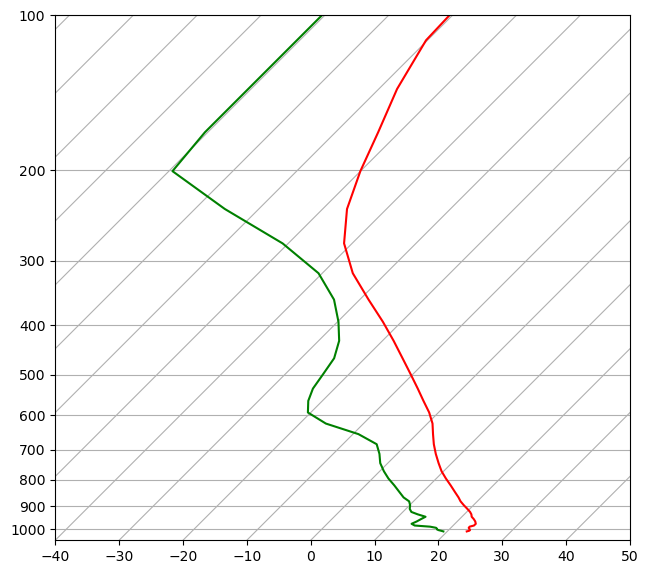

In [77]:
skewt_plot(wrf_data, 'Modeled', (2023,7,21,0,0))

In [73]:
wrf_data.wdir.metpy.dequantify()

<xarray.DataArray 'uvmet_wspd_wdir' (bottom_top: 47)> Size: 188B
array([211.66339 , 203.69458 , 198.17213 , 192.84262 , 186.84758 ,
       179.38016 , 170.05614 , 163.85645 , 153.10065 , 139.04597 ,
       121.94021 ,  95.663956,  61.59958 ,  25.835327, 352.43878 ,
       342.82596 , 344.87912 , 345.09567 , 333.29373 , 313.7196  ,
       309.8659  , 314.89618 , 315.6775  , 311.60135 , 307.19376 ,
       300.80807 , 290.16736 , 277.5312  , 268.8721  , 264.9713  ,
       263.38043 , 263.3202  , 261.88617 , 257.77936 , 253.03453 ,
       250.80217 , 251.75745 , 254.1155  , 257.17245 , 261.1651  ,
       264.172   , 262.9715  , 254.43398 , 176.91742 , 104.37501 ,
       107.82464 ,  95.0345  ], dtype=float32)
Coordinates:
    wspd_wdir     <U4 16B 'wdir'
    XLONG         float32 4B -72.87
    XLAT          float32 4B 40.87
    XTIME         float32 4B 1.44e+03
    Time          datetime64[ns] 8B 2023-07-21
    latlon_coord  object 8B CoordPair(lat=40.87, lon=-72.87)
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  earth rotated wspd,wdir
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.000003814...
    units:        meter / second

In [45]:
ua_data.t

array([ 23. ,  23. ,  23. ,  23. ,  23. ,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   9.6,   7.8,   nan,   3.2,   1.2,   nan,
         nan,   nan, -10.3,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan, -49.3,   nan,   nan,   nan,   nan,   nan,   nan,
         nan, -44.3])

In [79]:
wrf_ds['U']

<class 'netCDF4._netCDF4.Variable'>
float32 U(Time, bottom_top, south_north, west_east_stag)
    FieldType: 104
    MemoryOrder: XYZ
    description: x-wind component
    units: m s-1
    stagger: X
    coordinates: XLONG_U XLAT_U XTIME
unlimited dimensions: Time
current shape = (1, 47, 285, 331)
filling on, default _FillValue of 9.969209968386869e+36 used